# Annex 1- DPA quenching

A multi compartment model consisting of an extracellular reservoir ($E$), an extracelular ($M1$) and intracelular membrane leaflets ($M2$), and a cytosolic compartment ($C$) was implemented as a series of differential equations in Python language. Rate constant from extracelular and intracellular compartments to membrane were the same ($a$), and rates from membrane to both extracellular and intracellular compartments were the same ($b$) (Cooper et al., 1981). Rates between the two membrane leaflets ($v_1$ , $v_2$) were obtained by extracting time constants for charge movement from whole-cell membrane capacitance measurements in presence of 4 μM DPA in mast cells (Oberhauser and Fernadez, 1995). Time constants in function of voltage follow a bell-shaped curve, then we fitted from negative voltages to the peak with the equation:

\begin{equation}
{
v_2 = B_0 \cdot exp(-slp_2\cdot V\cdot \frac{F}{RT})
}
\end{equation}

while data from peak towards positive voltages was fitted to:  

\begin{equation}
{
v_1 = A_0 \cdot exp(-slp_1\cdot V\cdot \frac{F}{RT})
}
\end{equation}

From the fit we obtained $A_0$, $B_0$, $slp_1$, $slp_2$, which were used for the model. $R$ is the gas constant, $T$ is the absolute temperature and, $F$ is the Faraday constant; $V$ was assumed -30 mV from our previous work. 

Fluorescence quenching was fitted to the model to obtain rate constants $a$ and $b$, and parameters $A_0$, $B_0$, $slp_1$, $slp_2$ to calculate rate constants $v_1$ and $v_2$. With all this rates we run the model to calculate probabilities to find molecules in each compartment.  By assuming DPA density at equilibrium $10^{-4}$ molecules/A2 (Oberhauser and Fernandez 1995), a cell with diameter of 40 μm and a membrane width of 10 nm, we were able to transform probabilities to concentration in membrane and cytosol. 

Cooper et al (1981) 
https://doi.org/10.1002/jps.2600700110

Oberhauser and Fernadez (1995)
https://dx.doi.org/10.1016%2FS0006-3495(95)79918-0

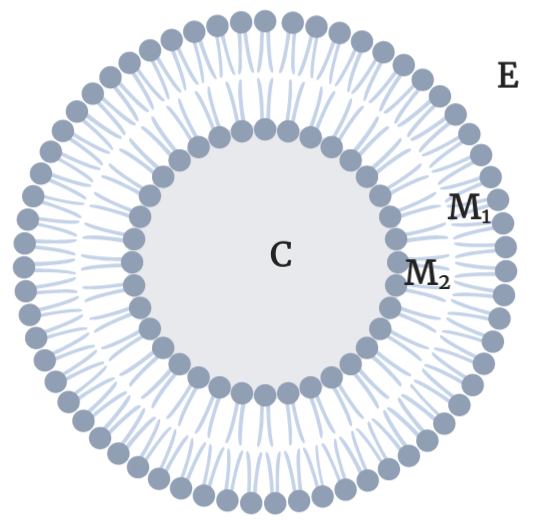

In [ ]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import time as tm
from scipy.optimize import curve_fit
from scipy.stats import mannwhitneyu
from scipy.signal import savgol_filter
import matplotlib.gridspec as gridspec
import math

# This file has corrected values of fitted parameters

In [1]:
#Load from google colab
#from google.colab import drive
#drive.mount('/content/drive')

Delete points before DPA application

Text(0.5,0.98,'delete points before fitting')

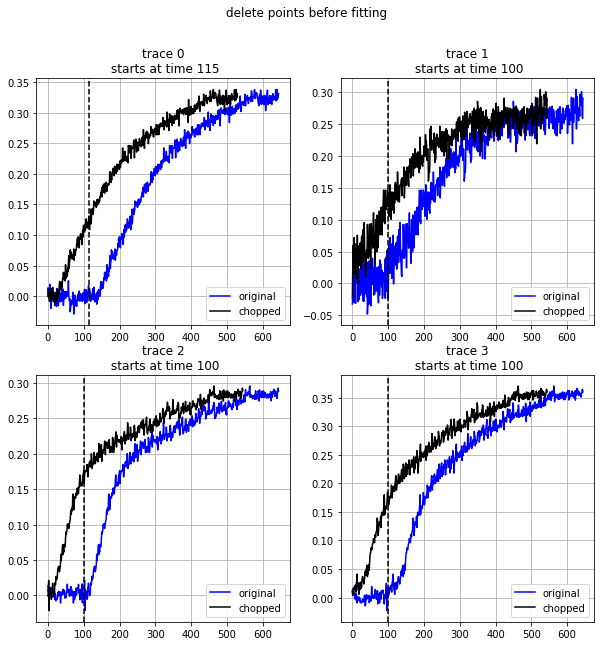

In [ ]:
# remove baseline before fitting

trazos_pm   = -np.genfromtxt("pm_raw.csv", delimiter=',') #Local
#trazos_pm   = -np.genfromtxt("/content/drive/My Drive/Colab Notebooks/pm_raw.csv", delimiter=',')  #Cola1bs
#trazos_pm   = -np.genfromtxt("pm_raw.csv", delimiter=',')
t_trazos= np.linspace(0, np.shape(trazos_pm)[0], np.shape(trazos_pm)[0])
#t_dele = [130,90,110,95]
t_dele = [115,100,100,100]
#dele = range(t_dele)
plt.figure(figsize=(10,10))

for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(t_trazos,trazos_pm[:,i], "b", label= "original")    
    plt.axvline(t_dele[i], color ="k", ls="--")
    dele = range(t_dele[i])
    trazos_pm_d = np.delete(trazos_pm, dele,  axis=0 )
    t_trazos_d= np.linspace(0, np.shape(trazos_pm_d)[0], np.shape(trazos_pm_d)[0])
    plt.plot(t_trazos_d,trazos_pm_d[:,i], "k",label= "chopped")
    tit_str = "trace "+str(i)+"\n starts at time "+str(t_dele[i])
    plt.title(tit_str)
    plt.grid()
    plt.legend()
plt.suptitle("delete points before fitting")
#plt.savefig("fig2.png")


Kinetic model is

    a            b
0.002352     0.001270
0.002767     0.003252
0.003611     0.004305
0.003421     0.002196
------------------------------
0.003038     0.002756   mean
0.000252     0.000568   sd
------------------------------
------------------------------
 a : 0.0030 +- 0.0003
 b : 0.0028 +- 0.0006


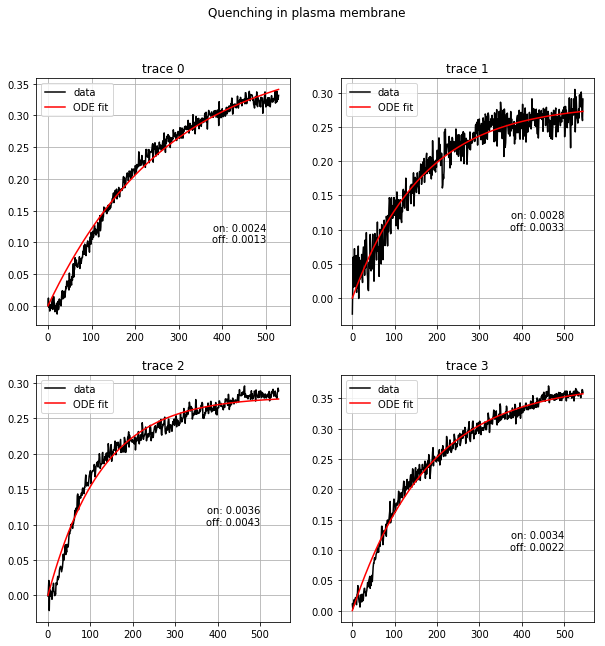

In [ ]:
### fit data to four compartment model, one v-dep transition (PM)
# 
# Function to fit the model
def y(t, a,b):
    def f(z, t, a,b):  # Model , a and b are rate constant to be fitted
        c1,m1,m2 = z   # Probability to be in each compartment, can be transformed in concentration
        A0 = 10643.1
        slp_a = -.215
        V = -30  # membrane potential
        v2 = A0*np.exp(-slp_a*V/58) # .002 # voltage dependent rate constant
        B0 = 8624.9
        slp_b = .278
        v1 = B0*np.exp((1-slp_b)*V/58) # .002 # voltage dependent rate constant
        
        dydt = [-a*c1 + b*m1,            # C1
            a*c1 + v2*m2 - b*m1 - v1*m1, # M1
            v1*m1 + a*(1- c1 -m1 -m2) - v2*m2 -b*m2]  # M2
            #b*m2 -a*(1- c1 -m1 -m2)]     # Cyto
        return dydt
    y0=[1,0,0]  # initial condition for each compartment
    y = integrate.odeint(f, y0, t, args=(a,b))  # solve ODE
    return y[:,1] # the output is m2

#trazos_pm   = -np.genfromtxt("pm_raw.csv", delimiter=',')
trazos_pm   = -np.genfromtxt("/content/drive/My Drive/Colab Notebooks/pm_raw.csv", delimiter=',')
t_trazos= np.linspace(0, np.shape(trazos_pm)[0], np.shape(trazos_pm)[0]) # time array
t_dele = [130,90,110,95]    # point numbers to be removed for each experiment
t_dele = [115,100,100,100]  # point numbers to be removed for each experiment
#dele = range(t_dele)
a,b = [], []
#tr_0, tr_1, tr_2, tr_3 =[], [], [], []
#tr = [tr_0, tr_1, tr_2, tr_3]
plt.figure(figsize=(10,10))
print("    a            b")
#--fit traces to model and plot---
for i in range(4):
    plt.subplot(2,2,i+1)
    #plt.plot(t_trazos,trazos_pm[:,i], "b", label= "original")    
    dele = range(t_dele[i])  # array of indeces to be removed
    #trazos_pm_d = np.delete(trazos_pm[:,i], dele,  axis=0 )
    # remove inital data points
    trazos_pm_d = np.delete(trazos_pm, dele,  axis=0 )
    # create time array
    t_trazos_d= np.linspace(0, np.shape(trazos_pm_d)[0], np.shape(trazos_pm_d)[0]) 
    #print (np.shape(trazos_pm_d), np.shape(t_trazos_d))
    # plot data
    plt.plot(t_trazos_d,trazos_pm_d[:,i], "k",label= "data")
    # fit data to model with guesses (p0)
    popt, cov = curve_fit(y, t_trazos_d, trazos_pm_d[:,i], p0 = [0.006,0.002] )
                         #bounds= ((0.002,0.001,0),(.01,.009,1)))
    # plot fitting
    plt.plot(t_trazos_d, y(t_trazos_d, *popt), '-r', label="ODE fit")
    print("%.6f" % popt[0] +"     " +"%.6f" % popt[1])
    a.append(popt[0]) 
    b.append(popt[1])
    tit_str = "trace "+str(i) #+"\n starts at time "+str(t_dele[i])
    plt.title(tit_str)
    txt_fit = "on: %.4f" % popt[0] + "\noff: %.4f" % popt[1]
    plt.text(500, .1,txt_fit, horizontalalignment="right") # , weight = 'bold' # y_txt[i]
    plt.grid()
    plt.legend()
plt.suptitle("Quenching in plasma membrane")
print("------------------------------")
print("%.6f" %  np.mean(a) +"     "+ "%.6f   mean" % np.mean(b))
sd_a = np.std(a)/np.sqrt(4)
sd_b = np.std(b)/np.sqrt(4)
print("%.6f" %  sd_a +"     " "%.6f   sd" % sd_b)
print("------------------------------")
print("------------------------------")
print(" a : %.4f" %  np.mean(a) + " +- %.4f" % (np.std(a)/np.sqrt(4)))
print(" b : %.4f" %  np.mean(b) + " +- %.4f" % (np.std(b)/np.sqrt(4)))
#plt.savefig("ODE_fit_pm.png")

Fitting to different membrane potentials

Text(0.5,0.98,'Quenching in plasma membrane')

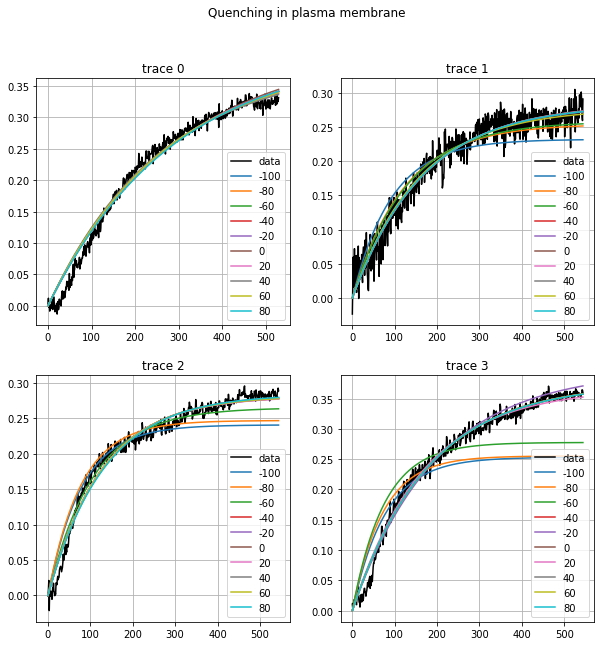

In [ ]:
### fit data to six compartment model  (v-dep)
# transition within plasma membrane is voltage dependent
#---Model----
def y(t, a,b):
    def f(z, t, a,b,j):
        c1,m1,m2 = z
        A0 = 10643.1
        slp_a = -.215
        volt = np.arange(-100,100,20)
        v2 = A0*np.exp(-slp_a*volt[j]/58) # .002 # 
        B0 = 8624.9
        slp_b = .278
        v1 = B0*np.exp((1-slp_b)*volt[j]/58) # .002 # 
        
        dydt = [-a*c1 + b*m1,            # C1
            a*c1 + v2*m2 - b*m1 - v1*m1, # M1
            v1*m1 + a*(1- c1 -m1 -m2) - v2*m2 -b*m2]  # M2
            #b*m2 -a*(1- c1 -m1 -m2)]     # Cyto
        return dydt
    y0=[1,0,0]
    y = integrate.odeint(f, y0, t, args=(a,b,j))
    return y[:,2] #

trazos_pm   = -np.genfromtxt("/content/drive/My Drive/Colab Notebooks/pm_raw.csv", delimiter=',')
#t_trazos= np.linspace(0, np.shape(trazos_pm)[0], np.shape(trazos_pm)[0])
t_dele = [130,90,110,95]
t_dele = [115,100,100,100]
#dele = range(t_dele)
#a,b = [], []
#tr_0, tr_1, tr_2, tr_3 =[], [], [], []
#tr = [tr_0, tr_1, tr_2, tr_3]
plt.figure(figsize=(10,10))
#print(" \t\ta  \tb \tr^2")
#
#--fit traces to model and plot---
volt = np.arange(-100,100,20)
for i in range(4):
    plt.subplot(2,2,i+1)
    #plt.plot(t_trazos,trazos_pm[:,i], "b", label= "original")    
    dele = range(t_dele[i])
    #trazos_pm_d = np.delete(trazos_pm[:,i], dele,  axis=0 )
    trazos_pm_d = np.delete(trazos_pm, dele,  axis=0 )
    t_trazos_d= np.linspace(0, np.shape(trazos_pm_d)[0], np.shape(trazos_pm_d)[0]) 
    #print (np.shape(trazos_pm_d), np.shape(t_trazos_d))
    plt.plot(t_trazos_d,trazos_pm_d[:,i], "k",label= "data")
    #--fit to a range of voltages------
    for j in range(len(volt)):
        popt, cov = curve_fit(y, t_trazos_d, trazos_pm_d[:,i], p0 = [0.006,0.002] )
                             #bounds= ((0.002,0.001,0),(.01,.009,1)))
        plt.plot(t_trazos_d, y(t_trazos_d, *popt),  label=str(volt[j]))
        # calculate R squared
        residuals = trazos_pm_d[:,i] - y(t_trazos_d, *popt)  # residuals
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((trazos_pm_d[:,i] -np.mean(trazos_pm_d[:,i]))**2)
        r_squared =  1 - (ss_res / ss_tot) 
        #print(str(volt[j]) + " mV" +"\t\t%.4f" % popt[0] +"\t%.4f" % popt[1]
             #+ "\t%.4f" % r_squared)
    #a.append(popt[0])
    #b.append(popt[1])
    #print("----")
    tit_str = "trace "+str(i) #+"\n starts at time "+str(t_dele[i])
    plt.title(tit_str)
    #txt_fit = "on: %.4f" % popt[0] + "\noff: %.4f" % popt[1] 
    #plt.text(500, .1,txt_fit, horizontalalignment="right") # , weight = 'bold' # y_txt[i]
    plt.grid()
    plt.legend()
plt.suptitle("Quenching in plasma membrane")
#plt.savefig("ODE_fit_pm_v_dep.png")

### Runing the model

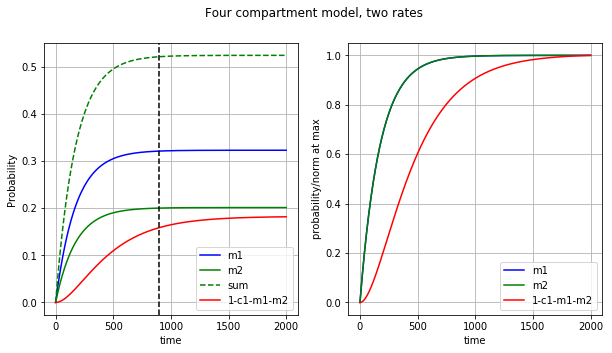

In [ ]:
"""Since there is no effect of voltage, we averages rate constants
obtainded from indivual fits to run the model
"""

a_fit = np.mean(a)
b_fit = np.mean(b)
# same model used before
def ff(z, t, a,b):  # Model , a and b are rate constant to be fitted
    c1,m1,m2 = z   # Probability to be in each compartment, can be transformed in concentration
    A0 = 10643.1
    slp_a = -.215
    V = -30  # membrane potential
    v2 = A0*np.exp(-slp_a*V/58) # .002 # voltage dependent rate constant
    B0 = 8624.9
    slp_b = .278 # 1.278
    v1 = B0*np.exp((1-slp_b)*V/58) # .002 # voltage dependent rate constant
        
    dydt = [-a*c1 + b*m1,            # C1
        a*c1 + v2*m2 - b*m1 - v1*m1, # M1
        v1*m1 + a*(1- c1 -m1 -m2) - v2*m2 -b*m2]  # M2
        #b*m2 -a*(1- c1 -m1 -m2)]     # Cyto
    return dydt

y0=[1,0,0] #initial values
t_trazos= np.arange(0, 2000, 1)   # time array
# Solve ODE
y_fit = integrate.odeint(ff, y0, t=t_trazos, args=(a_fit,b_fit))
# each column of y_fit is one compartment: c1, m1, m2, 1-c1-m1-m2 (c2,cytosol) 
y_fit_comp = 1- y_fit[:,0] -y_fit[:,1] -y_fit[:,2] # this is c2
plt.figure(figsize=(10,5))

#plot all probabilities
plt.subplot(1,2,1)
#plt.plot(t_trazos, y_fit[:,0], "k", label ="c1")
plt.plot(t_trazos, y_fit[:,1], "b", label ="m1")  # plot m1
plt.plot(t_trazos, y_fit[:,2], "g", label ="m2")  # plot c2 (cytosol)
plt.plot(t_trazos, y_fit[:,2] + y_fit[:,1], "--g", label ="sum")  # plot c2 (cytosol)
plt.plot(t_trazos, y_fit_comp, "r", label ="1-c1-m1-m2")  # plot m2
plt.axvline(900, ls="--", color="k")
V_m =12 # m^3
#magia_m1 = ((moles_m1+ moles_m2/V_m) * (y_fit[:,1] + y_fit[:,2])  # M1
#magia_cyt = (moles_cyt/v_cyt)*y_fit_comp)

plt.legend(loc=4)
plt.xlabel("time")
plt.ylabel("Probability")
plt.grid()

#plot all normalized probabilities
plt.subplot(1,2,2)
#plt.plot(t_trazos, y_1[:,0]/np.amax(y_1[:,0]) , "k", label ="c1")
plt.plot(t_trazos, y_fit[:,1]/np.amax(y_fit[:,1]), "b", label ="m1")
plt.plot(t_trazos, y_fit[:,2]/np.amax(y_fit[:,2]), "g", label ="m2")
plt.plot(t_trazos, y_fit_comp/np.amax(y_fit_comp), "r", label ="1-c1-m1-m2")

plt.legend(loc=4)
plt.xlabel("time")
plt.ylabel("probability/norm at max")
plt.suptitle("Four compartment model, two rates")
plt.grid()

### DPA concentration in plasma membrane
By using density of DPA in plasma membrane in similar conditios (10**-4  molec / Angs^2), the volume of a speherical cell of 20 micometers dimaeter and 10 nm membrane thickness, we calculate maximum DPA concentration in membrane.

In [ ]:
# Number of molecules in membrane
density = 10**-4 # molec / Angs^2
ra = 20 # um
s_a  = 4*math.pi*((ra*10000 )**2) # surface in Angstrong^2
nu_molec = density*s_a 
print ("# molec per cell %.0f" %nu_molec)
# vol cell
vol_cell_um = 4*math.pi*(ra**3)/3 # in um^3
print ("cell volume is %.1f" %vol_cell_um  +" um^3")
# vol membrane
ra_m = .01 + ra  # radius 10 nm bigger than ra
vol_cell_um_m = 4*math.pi*(ra_m**3)/3 # in um^3
vol_mem = vol_cell_um_m - vol_cell_um
print ("mem  volume is %.1f" %vol_mem  +" um^3")
vol_cyto = .3*vol_cell_um
print ("cyto volume is %.1f" %vol_cyto  +" um^3")
print ("-------")
# DPA conc in membrane
avo = 6.023*10**23
dpa_pm = (nu_molec/avo)/(vol_cell_um*10**-15)  # *10**15 convertion um3 to L
print("[DPA]_pm " + str(dpa_pm) +"M" ) # %.1f

# molec per cell 50265482
cell volume is 33510.3 um^3
mem  volume is 50.3 um^3
cyto volume is 10053.1 um^3
-------
[DPA]_pm 2.49045326249e-06M


### DPA concentration in compartments
By using three simple rule with the maximum DPA concentration in plasma membrane, probabilities were transformed probabilities into number of molecules. Concentration was obtained by dividing by Avogadros number and subsecuently by membrane volume.

concentration at 900 s
conc in PM 0.0016504099023167157 M
conc in cyto 1.8850645190994634e-06 M


/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


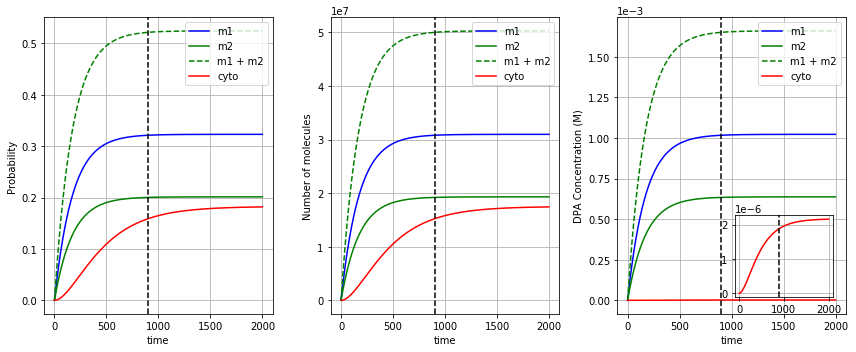

In [ ]:
# calculate number of molecules
mem_ss = y_fit[-1,1] + y_fit[-1,2]  # M1 + M2 at steady state
# number of molecules calculated by rule of three using known density  
#  mem_ss (0.55)   -> num_molec in membrane (12566371)
#    array         ->    x
# x = array * number_of_molecules / mem_ss
m1_num_molec = y_fit[:,1]*nu_molec/mem_ss  
m2_num_molec = y_fit[:,2]*nu_molec/mem_ss
cyto_num_molec = y_fit_comp*nu_molec/mem_ss

# calculate concentration
#  [] = (num_molec/avogadro)/vol (in liters)
m1_conc = (m1_num_molec/avo)/(vol_mem*10**-15)
m2_conc = (m2_num_molec/avo)/(vol_mem*10**-15)
mem_conc = ((m1_num_molec +m2_num_molec)/avo)/(vol_mem*10**-15)
vol_cyto = .4*(vol_cell_um*10**-15)  # cytoplasm is one third of cell volume
cyt_conc = (cyto_num_molec/avo)/(vol_cyto)

# Plot probability
fig = plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
#plt.plot(t_trazos, y_fit[:,0], "k", label ="c1")
plt.plot(t_trazos, y_fit[:,1], "b", label ="m1")  # plot m1
plt.plot(t_trazos, y_fit[:,2], "g", label ="m2")  # plot c2 (cytosol)
plt.plot(t_trazos, y_fit[:,2] + y_fit[:,1], "--g", label ="m1 + m2")  # plot c2 (cytosol)
plt.plot(t_trazos, y_fit_comp, "r", label ="cyto")  # plot m2
plt.axvline(900, ls="--", color="k")
plt.ylabel("Probability")
plt.legend(loc=1)
plt.xlabel("time")
plt.grid()

# Plot number of molecules
plt.subplot(1,3,2)
#plt.plot(t_trazos, y_fit[:,0], "k", label ="c1")
plt.plot(t_trazos, m1_num_molec, "b", label ="m1")  # plot m1
plt.plot(t_trazos, m2_num_molec, "g", label ="m2")  # plot c2 (cytosol)
plt.plot(t_trazos, m1_num_molec + m2_num_molec, "--g", label ="m1 + m2")  # plot c2 (cytosol)
plt.plot(t_trazos, cyto_num_molec, "r", label ="cyto")  # plot m2
plt.axvline(900, ls="--", color="k")
plt.ylabel("Number of molecules")
plt.legend(loc=1)
plt.xlabel("time")
plt.grid()

# Plot concentration
ax1 = plt.subplot(1,3,3)
#plt.plot(t_trazos, y_fit[:,0], "k", label ="c1")
ax1.plot(t_trazos, m1_conc, "b", label ="m1")  # plot m1
ax1.plot(t_trazos, m2_conc, "g", label ="m2")  # plot c2 (cytosol)
ax1.plot(t_trazos, mem_conc, "--g", label ="m1 + m2")  # plot c2 (cytosol)
ax1.plot(t_trazos, cyt_conc, "r", label ="cyto")  # plot m2
ax1.set_xlabel("time")
ax1.set_ylabel("DPA Concentration (M)")
ax1.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax1.axvline(900, ls="--", color="k")
ax1.set_ylabel("DPA Concentration (M)")
ax1.legend(loc=1)
ax1.set_xlabel("time")
ax1.grid()
#ax1.axvline(520, ls="--", color="r")
[x0,y0], [x1, y1] = fig.transFigure.inverted().transform(
            ax1.transAxes.transform([[0.8, 0.05], [1.3, 0.35]]))
ax2 = fig.add_axes([x0, y0, x1-x0, y1-y0 ])
ax2.plot(t_trazos, cyt_conc, "r", label ="cyto")  # plot m2
ax2.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax2.axvline(900, ls="--", color="k")
ax2.grid()
#for i in range(3):
#    plt.subplot(1,3,i+1)
#    plt.legend(loc=1)
#    plt.xlabel("time")
#    plt.grid()
print("concentration at 900 s")
print("conc in PM "+ str(mem_conc[899])+ " M")
print("conc in cyto "+ str(cyt_conc[899])+ " M")
#print("conc in lyso lumen "+ mem_conc[-1])
plt.tight_layout()

plt.savefig("probs_and_concs.png", dpi=300)

In [ ]:
print(np.shape(t_trazos))

(2000,)


Plot extracellular, membrane (m1 + m2) and cytosol

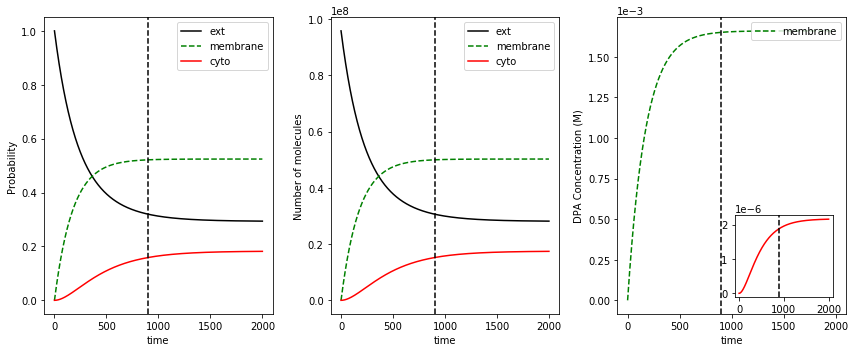

In [ ]:
# Plot probability
fig = plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.plot(t_trazos, y_fit[:,0], "k", label ="ext")
#plt.plot(t_trazos, y_fit[:,1], "b", label ="m1")  # plot m1
#plt.plot(t_trazos, y_fit[:,2], "g", label ="m2")  # plot c2 (cytosol)
plt.plot(t_trazos, y_fit[:,2] + y_fit[:,1], "--g", label ="membrane")  # plot c2 (cytosol)
plt.plot(t_trazos, y_fit_comp, "r", label ="cyto")  # plot m2
plt.axvline(900, ls="--", color="k")
plt.ylabel("Probability")
plt.legend(loc=1)
plt.xlabel("time")
#plt.grid()

# Plot number of molecules
ext_num_molec = y_fit[:,0]*nu_molec/mem_ss  
plt.subplot(1,3,2)
plt.plot(t_trazos, ext_num_molec, "k", label ="ext")
#plt.plot(t_trazos, m1_num_molec, "b", label ="m1")  # plot m1
#plt.plot(t_trazos, m2_num_molec, "g", label ="m2")  # plot c2 (cytosol)
plt.plot(t_trazos, m1_num_molec + m2_num_molec, "--g", label ="membrane")  # plot c2 (cytosol)
plt.plot(t_trazos, cyto_num_molec, "r", label ="cyto")  # plot m2
plt.axvline(900, ls="--", color="k")
plt.ylabel("Number of molecules")
plt.legend(loc=1)
plt.xlabel("time")
#plt.grid()

# Plot concentration
ax1 = plt.subplot(1,3,3)
#plt.plot(t_trazos, y_fit[:,0], "k", label ="c1")
#plt.plot(t_trazos, m1_conc, "b", label ="m1")  # plot m1
#plt.plot(t_trazos, m2_conc, "g", label ="m2")  # plot c2 (cytosol)
ax1.plot(t_trazos, mem_conc, "--g", label ="membrane")  # plot c2 (cytosol)
#ax1.plot(t_trazos, cyt_conc, "r", label ="cyto")  # plot m2
ax1.legend(loc=4)
ax1.set_xlabel("time")
ax1.set_ylabel("DPA Concentration (M)")
ax1.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax1.axvline(900, ls="--", color="k")
[x0,y0], [x1, y1] = fig.transFigure.inverted().transform(
            ax1.transAxes.transform([[0.8, 0.05], [1.3, 0.35]]))
ax1.legend(loc=1)
ax1.set_xlabel("time")
#ax1.grid()
ax2 = fig.add_axes([x0, y0, x1-x0, y1-y0 ])
ax2.plot(t_trazos, cyt_conc, "r", label ="cyto")  # plot m2
ax2.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax2.axvline(900, ls="--", color="k")
#ax2.grid()

plt.tight_layout()

### Effect of cytoplasm proportion on concentration. 
Calculate concentration on different proportions of cytoplasm volume/cell volume

concentrations in cytosol at 900 s
proportion 0.2 conc in cyto is 3.7701290381989267e-06
proportion 0.3 conc in cyto is 2.5134193587992845e-06
proportion 0.4 conc in cyto is 1.8850645190994634e-06
proportion 0.5 conc in cyto is 1.5080516152795708e-06


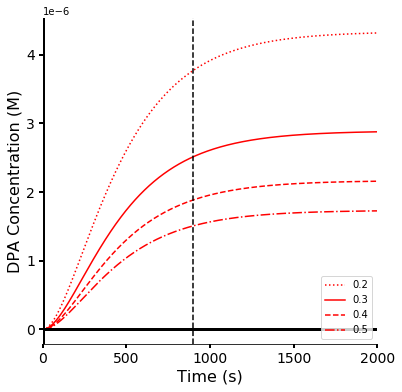

In [ ]:
# Effect of cytoplasm proprtion on concentration
props = [.2, .3, .4, .5 ]
l_s = [":", "-", "--", "-."]
#plt.plot(t_trazos, mem_conc, "--g", label ="m1 + m2")  # plot c2 (cytosol)
#plt.figure(figsize=(6,6))
fig,ax = plt.subplots(figsize=(6,6))
print("concentrations in cytosol at 900 s")
for i in range(len(props)):
    vol_cyto = props[i]*(vol_cell_um*10**-15)  # cytoplasm is one third of cell volume
    cyt_conc = (cyto_num_molec/avo)/(vol_cyto)
    ax.plot(t_trazos, cyt_conc, "r", ls=l_s[i], label =str(props[i]))  # 
    print("proportion " +str(props[i]) +" conc in cyto is "+ str(cyt_conc[899]))
#ax.set_ylim(0,1e-5)
ax.set_xlim(0,2000)
ax.legend(loc=4)
ax.set_xlabel("Time (s)", fontsize=16)
ax.set_ylabel("DPA Concentration (M)", fontsize=16)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax.axvline(900, ls="--", color="k")
# axis 
ax.axvline( linewidth =4, color="k")
ax.axhline( linewidth =3, color="k")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis="both", width=2, length=4, labelsize=14)

plt.savefig("cyt_concentration.png", dpi=300)
plt.savefig("cyt_concentration.pdf", dpi=300)

## Concentrations in Lysosome
Model with lysosomal membranes and lumen


![title](kinetic_model_pm_ly.jpg)

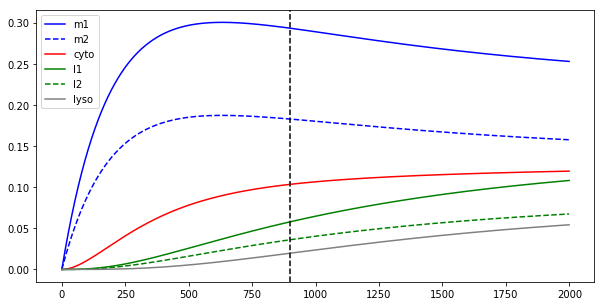

In [ ]:
a_fit = np.mean(a)
b_fit = np.mean(b)
def ff2(z, t, a,b):  # Model , a and b are rate constant to be fitted
    c1,m1,m2,l1,l2,u = z   # Probability to be in each compartment, can be transformed in concentration
    A0 = 10643.1
    slp_a = -.215
    V = -30  # membrane potential
    v2 = A0*np.exp(-slp_a*V/58) # .002 # voltage dependent rate constant
    B0 = 8624.9
    slp_b = .278 # 1.278
    v1 = B0*np.exp((1-slp_b)*V/58) # .002 # voltage dependent rate constant
        
    #dydt = [-a*c1 + b*m1,            # C1
    #    a*c1 + v2*m2 - b*m1 - v1*m1, # M1
    #    v1*m1 + a*(1- c1 -m1 -m2) - v2*m2 -b*m2]  # M2
    #   #b*m2 -a*(1- c1 -m1 -m2)]     # Cyto
        
    dydt = [-a*c1 + b*m1, # C1
        a*c1 + v2*m2 - b*m1 - v1*m1, # M1
        v1*m1 + a*(1- c1 -m1 -m2 -l1 -l2 -u) - v2*m2 -b*m2,  # M2
        #b*m2 + b*l1 -2*a*(1- c1 -m1 -m2-l1 -l2 -u),    # C3  cyto
        a*(1- c1 -m1 -m2 -l1 -l2 -u) +v2*l2 -b*l1 - v1*l1,    # L1 
        v1*l1 -v2*l2 + a*u - b*l2,  # L2
        b*l2 - a*u]    #lyso
    
    return dydt

y0=[1,0,0,0,0,0] #initial values
t_trazos= np.arange(0, 2000, 1)   # time array
# Solve ODE
y_fit = integrate.odeint(ff2, y0, t=t_trazos, args=(a_fit,b_fit))
# each column of y_fit is one compartment: c1, m1, m2, 1-c1-m1-m2 (c2,cytosol) 
y_fit_comp = 1- y_fit[:,0] -y_fit[:,1] -y_fit[:,2] -y_fit[:,3] -y_fit[:,4] -y_fit[:,5]# this is cyto

plt.figure(figsize=(10,5))
plt.plot(t_trazos, y_fit[:,1], "-b", label ="m1")  # plot m1
plt.plot(t_trazos, y_fit[:,2], "--b", label ="m2")  # plot c2 (cytosol)
#plt.plot(t_trazos, y_fit[:,2] + y_fit[:,1], "--g", label ="sum M")  # plot c2 (cytosol)
plt.plot(t_trazos, y_fit_comp, "r", label ="cyto")  # plot cyto
plt.plot(t_trazos, y_fit[:,3], "-g", label ="l1")  # plot l1
plt.plot(t_trazos, y_fit[:,4], "--g", label ="l2")  # plot l2
plt.plot(t_trazos, y_fit[:,5], "gray", label ="lyso")  # plot lyso
plt.axvline(900, ls="--", color="k")
plt.legend()

Calculating concentration in each compartment

conc in PM 		0.0019247837274073065 M
conc in cyto 		1.5686603520650605e-06 M
conc in lyso mem 	0.00037964824480784935 M
conc in lumen lyso 	7.962005492765757e-05 M


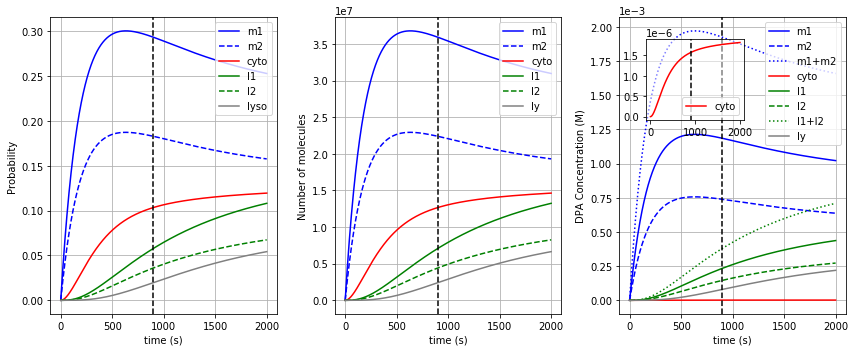

In [ ]:
# calculate number of molecules
mem_ss = y_fit[-1,1] + y_fit[-1,2]  # M1 + M2 at steady state
# number of molecules calculated by rule of three using known density  
#  mem_ss (0.55)   -> num_molec in membrane (12566371)
#    array         ->    x
# x = array * number_of_molecules / mem_ss
m1_num_molec_2 = y_fit[:,1]*nu_molec/mem_ss  
m2_num_molec_2 = y_fit[:,2]*nu_molec/mem_ss
cyto_num_molec_2 = y_fit_comp*nu_molec/mem_ss
l1_num_molec_2 = y_fit[:,3]*nu_molec/mem_ss  
l2_num_molec_2 = y_fit[:,4]*nu_molec/mem_ss
ly_num_molec_2 = y_fit[:,5]*nu_molec/mem_ss



# calculate concentration
#  [] = (num_molec/avogadro)/vol (in liters)
m1_conc_2 = (m1_num_molec_2/avo)/(vol_mem*10**-15)
m2_conc_2 = (m2_num_molec_2/avo)/(vol_mem*10**-15)
mem_conc_2 = ((m1_num_molec_2 +m2_num_molec_2)/avo)/(vol_mem*10**-15)
vol_cyto = .4*(vol_cell_um*10**-15)  # cytoplasm is one third of cell volume
cyt_conc_2 = (cyto_num_molec_2/avo)/(vol_cyto)

# vol lysosome
ra_l = .5  # radius lyso 0.5 micro meter
vol_lyso_um = 4*math.pi*(ra_l**3)/3 # in um^3
ra_l_m = .01 + ra_l  # radius 10 nm bigger than ra
vol_lyso_um_m = 4*math.pi*(ra_l_m**3)/3 # in um^3
vol_mem_lyso = vol_lyso_um_m - vol_lyso_um
#print ("mem  volume is %.1f" %vol_mem  +" um^3")

vol_cyto = .3*vol_cell_um

l1_conc = (l1_num_molec_2/avo)/(vol_mem*10**-15)
l2_conc = (l2_num_molec_2/avo)/(vol_mem*10**-15)
ly_mem_conc = l1_conc + l2_conc   #((l1_num_molec_2 +l2_num_molec_2)/avo)/(vol_mem*10**-15)
ly_conc = (ly_num_molec_2/avo)/(vol_mem*10**-15)

# Plot probability
fig = plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
#plt.plot(t_trazos, y_fit[:,0], "k", label ="c1")
plt.plot(t_trazos, y_fit[:,1], "b", label ="m1")  # plot m1
plt.plot(t_trazos, y_fit[:,2], "--b", label ="m2")  # plot c2 (cytosol)
plt.plot(t_trazos, y_fit_comp, "r", label ="cyto")  # plot cyto
plt.plot(t_trazos, y_fit[:,3], "-g", label ="l1")  # plot l1
plt.plot(t_trazos, y_fit[:,4], "--g", label ="l2")  # plot l2
plt.plot(t_trazos, y_fit[:,5], "gray", label ="lyso")  # plot lyso
#plt.plot(t_trazos, y_fit[:,2] + y_fit[:,1], "--g", label ="m1 + m2")  # plot c2 (cytosol)
#plt.plot(t_trazos, y_fit_comp, "r", label ="cyto")  # plot m2
plt.axvline(900, ls="--", color="k")
plt.ylabel("Probability")
plt.legend(loc=1)
plt.xlabel("time (s)")
plt.grid()

# Plot number of molecules
plt.subplot(1,3,2)
#plt.plot(t_trazos, y_fit[:,0], "k", label ="c1")
plt.plot(t_trazos, m1_num_molec_2, "b", label ="m1")  # plot m1
plt.plot(t_trazos, m2_num_molec_2, "--b", label ="m2")  # plot c2 (cytosol)
#plt.plot(t_trazos, m1_num_molec + m2_num_molec, "--g", label ="m1 + m2")  # plot c2 (cytosol)
plt.plot(t_trazos, cyto_num_molec_2, "r", label ="cyto")  # plot m2
plt.plot(t_trazos, l1_num_molec_2, "g", label ="l1")  # plot c2 (cytosol)
plt.plot(t_trazos, l2_num_molec_2, "--g", label ="l2")  # plot c2 (cytosol)
plt.plot(t_trazos, ly_num_molec_2, "gray", label ="ly")  # plot c2 (cytosol)

plt.axvline(900, ls="--", color="k")
plt.ylabel("Number of molecules")
plt.legend(loc=1)
plt.xlabel("time (s)")
plt.grid()

# Plot concentration
ax1 = plt.subplot(1,3,3)
#plt.plot(t_trazos, y_fit[:,0], "k", label ="c1")
ax1.plot(t_trazos, m1_conc_2, "b", label ="m1")  # plot m1
ax1.plot(t_trazos, m2_conc_2, "--b", label ="m2")  # plot c2 (cytosol)
ax1.plot(t_trazos, mem_conc_2, ":b", label ="m1+m2")  # plot c2 (cytosol)
ax1.plot(t_trazos, cyt_conc_2, "r", label ="cyto")  # plot m2
ax1.plot(t_trazos, l1_conc, "g", label ="l1")  # plot c2 (cytosol)
ax1.plot(t_trazos, l2_conc, "--g", label ="l2")  # plot c2 (cytosol)
ax1.plot(t_trazos, ly_mem_conc, ":g", label ="l1+l2")  # plot c2 (cytosol)
ax1.plot(t_trazos, ly_conc, color="gray", label ="ly")  # plot c2 (cytosol)

ax1.set_xlabel("time")
ax1.set_ylabel("DPA Concentration (M)")
ax1.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax1.axvline(900, ls="--", color="k")
ax1.set_ylabel("DPA Concentration (M)")
ax1.legend(loc=1)
ax1.set_xlabel("time (s)")
ax1.grid()
#ax1.axvline(520, ls="--", color="r")
[x0,y0], [x1, y1] = fig.transFigure.inverted().transform(
            ax1.transAxes.transform([[0.35, 0.7], [.85, 1.0]]))
            # [0.8, 0.05], [1.3, 0.35]

ax2 = fig.add_axes([x0, y0, x1-x0, y1-y0 ])
ax2.plot(t_trazos, cyt_conc_2, "r", label ="cyto")  # plot m2
ax2.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax2.axvline(900, ls="--", color="k")
#ax2.grid()
ax2.patch.set_alpha(.5)
ax2.legend(loc=4)

#for i in range(3):
#    plt.subplot(1,3,i+1)
#    plt.legend(loc=1)
#    plt.xlabel("time")
#    plt.grid()

print("conc in PM \t\t"+ str(mem_conc_2[899])+ " M")
print("conc in cyto \t\t"+ str(cyt_conc_2[899])+ " M")
print("conc in lyso mem \t"+ str(ly_mem_conc[899])+ " M")
print("conc in lumen lyso \t"+ str(ly_conc[899])+ " M")
#print("conc in cyto "+ str(cyt_conc[-1])+ " M")

plt.tight_layout()
plt.savefig("probs_and_concs_pm_ly.png", dpi=300)
